# Proyecto Final Lab Inteligencia (Imagenes): Método alternativo 

In [16]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.spatial import distance as dist
import argparse
import glob
from skimage.feature import hog
from skimage import exposure

## 7) Uso de un método alternativo para la extracción de características

Se utiliza el método HoG (Histograms of Gradients) para realizar la extracción de caractrísticas. Se reutilizan varias de las funciones utilizadas anteriormente.

### 7.1) Lectura de imagen (en RGB)

In [2]:
#Funcion que lear una imagen a RGB
def leerRGB (nombreImagen):
    #Lectura
    readImage = cv2.imread(nombreImagen)
    return readImage

In [7]:
test = leerRGB('logo.jpg')

In [8]:
cv2.imshow('image',test)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [9]:
#Dimensiones de cada una de las imagenes
test.shape

(400, 400, 3)

In [13]:
fd, hog_image = hog(test, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

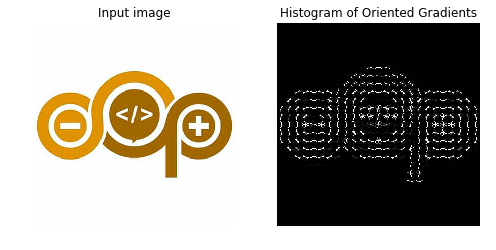

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(test, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

### 7.2) División de la imagen en razones 1:2 (6filasx3columas)

In [190]:
#Funcion que recorte la imagen en 6x3 celdas. Devuelve 18 submatrices.
def divCeldasAlt(imRGB):
    #division
    R = imRGB[:,:,0]
    G = imRGB[:,:,1]
    B = imRGB[:,:,2]
    #Dimensiones de la imagen
    alto,ancho,prof = imRGB.shape
    #Nuevas dimensiones
    nuevoAlto = int(alto/6)
    nuevoAncho = int(ancho/3)
    #Creacion de las tres matrices (inicialmente vacias).
    Rdiv = np.zeros([nuevoAlto,nuevoAncho,18])
    Gdiv = np.zeros([nuevoAlto,nuevoAncho,18])
    Bdiv = np.zeros([nuevoAlto,nuevoAncho,18])
    #Dividir imagen
    vecDivisionesAlto = [0,nuevoAlto,nuevoAlto,nuevoAlto*2,nuevoAlto*2,nuevoAlto*3,nuevoAlto*3,nuevoAlto*4,nuevoAlto*4,nuevoAlto*5,nuevoAlto*5,nuevoAlto*6]
    vecDivisionesAncho = [0,nuevoAncho,nuevoAncho,nuevoAncho*2,nuevoAncho*2,nuevoAncho*3]
    count = 0
    count1 = 0
    while count1 <= 11:
        count2 = 0
        while count2 <= 5:
            Rdiv[:,:,count] = R[vecDivisionesAlto[count1]:vecDivisionesAlto[count1+1],vecDivisionesAncho[count2]:vecDivisionesAncho[count2+1]]
            Gdiv[:,:,count] = G[vecDivisionesAlto[count1]:vecDivisionesAlto[count1+1],vecDivisionesAncho[count2]:vecDivisionesAncho[count2+1]]
            Bdiv[:,:,count] = B[vecDivisionesAlto[count1]:vecDivisionesAlto[count1+1],vecDivisionesAncho[count2]:vecDivisionesAncho[count2+1]]
            count += 1
            count2 += 2
        count1 +=2  
        
    return np.uint8(Rdiv),np.uint8(Gdiv),np.uint8(Bdiv)

### 7.3) Cálculo de los gradientes.

In [204]:
#Funcion que calcule los gradientes de las matrices RGB en x e y.
def gradienteCartesianas(imRGB):
    #Se almacenan los valores en tres matrices, correspondientes a R,G y B.
    #Division de la imagen.
    Rdiv,Gdiv,Bdiv = divCeldasAlt(imRGB)
    #Calculo del gradiente en x e y.
    #R.
    gxR = cv2.Sobel(Rdiv, cv2.CV_32F, 1, 0, ksize=1)
    gyR = cv2.Sobel(Rdiv, cv2.CV_32F, 0, 1, ksize=1)
    #G
    gxG = cv2.Sobel(Gdiv, cv2.CV_32F, 1, 0, ksize=1)
    gyG = cv2.Sobel(Gdiv, cv2.CV_32F, 0, 1, ksize=1)
    #B
    gxB = cv2.Sobel(Bdiv, cv2.CV_32F, 1, 0, ksize=1)
    gyB = cv2.Sobel(Bdiv, cv2.CV_32F, 0, 1, ksize=1)
    return gxR,gyR,gxG,gyG,gxB,gyB

#Funcion que calcule las matrices de magnitud y orientación
def gradientePolares(imRGB):
    #Calculo del gradiente en polares.
    gxR,gyR,gxG,gyG,gxB,gyB = gradienteCartesianas(imRGB)
    #Paso a coordenadas polares.
    #R
    magR, angleR = cv2.cartToPolar(gxR, gyR, angleInDegrees=True)
    #G
    magG, angleG = cv2.cartToPolar(gxG, gyG, angleInDegrees=True)
    #B
    magB, angleB = cv2.cartToPolar(gxB, gyB, angleInDegrees=True)
    return magR,angleR,magG,angleG,magB,angleB

#Lo que se obtienen son matrices de dimensiones 408 por 1088 por 18.

### 7.4) Cálculo de los histogramas.

In [209]:
#Funcion que normalice histograma.
#Funcion que realice la normalización de histogramas
def normHist(histogram):
    sumaHist = np.sum(histogram)
    normHist = (1/sumaHist)*histogram
    normHist = np.ravel(normHist)
    return normHist

#Funcion que cree un histograma para una matriz de magnitudes y una matriz de angulo.
def creacionHistogramaIndividual(mag,angle):
    #Dimensiones de las divisiones
    altura,ancho = mag.shape
    #Creación del arreglo histograma
    hist = np.array([0,0,0,0,0,0,0,0,0])
    grados = np.array([0,20,40,60,80,100,120,140,160])
    #Generación histograma
    count1 = 0
    while count1 < altura:
        count2 = 0
        while count2 < ancho:
            valorAngulo = angle[count1,count2]
            valorMag = mag[count1,count2]
            if(np.isin(valorAngulo,grados)):
                #Casos de igualdad.
                if(valorAngulo<80):
                    if(valorAngulo==0.0):                    
                        hist[0] +=  valorMag
                    elif(valorAngulo==20.0):                    
                        hist[1] +=  valorMag
                    elif(valorAngulo==40.0):                    
                        hist[2] +=  valorMag
                    elif(valorAngulo==60.0):                    
                        hist[3] +=  valorMag
                else:
                    if(valorAngulo==80.0):                    
                        hist[4] +=  valorMag
                    elif(valorAngulo==100.0):                    
                        hist[5] +=  valorMag
                    elif(valorAngulo==120.0):                    
                        hist[6] +=  valorMag
                    elif(valorAngulo==140.0):                    
                        hist[7] +=  valorMag
                    elif(valorAngulo==160.0):                    
                        hist[8] +=  valorMag
            else:
                magMedio = valorMag/2
                #Caso Valores intermedios
                if(valorAngulo>160):
                    hist[8] += magMedio
                    hist[0] += magMedio
                elif(valorAngulo<80):
                    if((valorAngulo > 0.) & (valorAngulo<20.)):
                        hist[0] += magMedio
                        hist[1] += magMedio
                    elif((valorAngulo > 20.) & (valorAngulo<40.)):
                        hist[1] += magMedio
                        hist[2] += magMedio
                    elif((valorAngulo > 40.) & (valorAngulo<60.)):
                        hist[2] += magMedio
                        hist[3] += magMedio
                    elif((valorAngulo > 60.) & (valorAngulo<80.)):
                        hist[3] += magMedio
                        hist[4] += magMedio
                else:
                    if((valorAngulo > 80.) & (valorAngulo<100.)):
                        hist[4] += magMedio
                        hist[5] += magMedio
                    elif((valorAngulo > 100.) & (valorAngulo<120.)):
                        hist[5] += magMedio
                        hist[6] += magMedio
                    elif((valorAngulo > 120.) & (valorAngulo<140.)):
                        hist[6] += magMedio
                        hist[7] += magMedio
                    elif((valorAngulo > 140.) & (valorAngulo<160.)):
                        hist[7] += magMedio
                        hist[8] += magMedio
  
            count2 += 1
        count1 += 1
    histNormalizado = normHist(hist)
    return histNormalizado

#Funcion que concatene los histogramas de las divisiones para generar el histograma de canal.
def creacionHistogramaCanal(magCanal,angCanal):
    #Dimensiones.
    alto,ancho,prof = magCanal.shape
    #Creacion de arreglo del histograma conjunto
    histConjunto = np.zeros(prof*9)
    #Iteraciones sobre las distintas divisiones.
    count = 0
    while count < prof:
        histDivision = creacionHistogramaIndividual(magCanal[count],angCanal[count])
        histConjunto[count*9:count*9+9] = histDivision
        count += 1
    return histConjunto      
      
#Funcion que genere el histograma concatenado para una imagen.
def histogramaGradienteImagen(imRGB):
    #Calculo de los gradientes en polares.
    magR,angleR,magG,angleG,magB,angleB = gradientePolares(imRGB)
    #Calculo de los histogramas:
    histR = creacionHistogramaCanal(magR,angleR)
    histG = creacionHistogramaCanal(magG,angleG)
    histB = creacionHistogramaCanal(magB,angleB)
    #Concatenacion
    histTotal = np.concatenate((histR,histG,histB))
    #Resultado
    return histTotal

### 7.5) Definición de medidad de comparación 

In [210]:
def compareEuc(hist1,hist2):
    #Comparar.
    distancia = dist.euclidean(hist1, hist2,1)
    return distancia

### 7.6) Orden de resultados por relevancia.

#### 7.6.1) Incorporación de imagenes de la base de datos

Se realiza una adaptación del archivo anterior.

In [211]:
def extraerClaseAlternativo(stringClase):
    #Extraer la clase de la imagen
    clase = stringClase[1:4]
    claseNum = int(clase)
    return claseNum 

def incorporarDatabaseAlternativo():
    #Funcion que incorpore elementos del database, con el fin posterior de realizar las comparaciones.
    #Inicializa images para almacenar las imágenes
    images = {}
    #Recorrer el directorio
    #Directorio
    path = "img_database/*.jpg"
    #Loop.
    for imPath in glob.glob(path):
        #Nombre del archivo
        filename = imPath[imPath.rfind("\\")+1:]
        #Importar
        image = cv2.imread(imPath)
        #Almacenar en imagenes.
        images[filename] = image
    return images

def incorporarDatabaseHistAlternativo():
    #Funcion que calcule los histogramas del Database.
    # Inicializa el diccionario index, para almacenar el nombre de imagen con su histograma
    path = "img_database/*.jpg"
    #Creación de arreglos
    nombres = np.array([])
    clases = np.array([])
    histos = np.array([])
    count = 0
    #Loop.
    for imPath in glob.glob(path):
        #Nombre del archivo
        filename = imPath[imPath.rfind("\\")+1:]
        #Agregar nombre y clase
        nombres = np.append(nombres,str(filename))
        clases = np.append(clases,extraerClaseAlternativo(filename))
        #Obtener el histograma
        imagenSubida = leerRGB(imPath)
        histImagen = histogramaGradienteImagen(imagenSubida)
        #Incluir histograma
        if (count==0):
            histos=histImagen.T
            count = 1
        elif(count==1):
            histos = np.concatenate(([histos],[histImagen.T]),axis=0)
            count = 2
        else:
            histos = np.concatenate((histos,np.array([histImagen])),axis=0)
    return nombres,clases,histos

In [212]:
nombresHoG,clasesHoG,histosHoG = incorporarDatabaseHistAlternativo()

KeyboardInterrupt: 

#### 7.6.2) Comparación de Queries versus la  base de datos.

In [ ]:
def distanciaUnaImagenAlt(nombreImagenQuery):
    #Obtener histograma de la imagen query.
    histQuery = histogramaGradienteImagen(imagenQuery)
    #Seleccion de la matriz de histogramas a comparar.
    histComparar = histosHoG
    #Comparaciones:
    comparaciones = np.array([])
    for h in histComparar:
        distancia = compareEuc(h,histQuery)
        comparaciones = np.append(comparaciones,distancia)
    return comparaciones

In [ ]:
def compararQueriesAlt():
    #Funcion que compare las queries para el metodo alternativo
    # Inicializa el diccionario index, para almacenar el nombre de imagen con su histograma
    path2 = "img_query/*.jpg"
    #Creación de arreglos
    nombres = np.array([])
    clases = np.array([])
    comparaciones = np.array([])
    #Loop.
    count = 0
    for imPath in glob.glob(path2):
        #Nombre del archivo
        posName = imPath.rfind("\\")
        filename2 = imPath[posName + 1:]
        #Calcular vector de comparaciones y la clase
        vecComparaciones = distanciaUnaImagenAlt(imPath)
        #Agregar nombre
        nombres = np.append(nombres,str(filename2))
        #Incluir clases
        clases = np.append(clases,extraerClase(filename2))
        #Incluir histograma
        if (count==0):
            comparaciones=vecComparaciones.T
            count = 1
        elif(count==1):
            comparaciones = np.concatenate(([comparaciones],[vecComparaciones.T]),axis=0)
            count = 2
        else:
            comparaciones = np.concatenate((comparaciones,[vecComparaciones]),axis=0)
    return nombres,clases,comparaciones

In [ ]:
nombresQueryAlt,clasesQueryAlt,compQueryAlt = compararQueriesAlt()

### 7.7) Cálculo del Rank normalizado.

In [ ]:
#Funcion que calcule el Rank Normalizado para las figuras.
def rankNormalizadoIndividual(claseQuery,vectorComparaciones,vecNombresData,nDivisiones):
    #Numero total de elementos en el conjunto.
    N = len(nombres5)    #Elementos del conjunto de la misma clase que el elemnto de la Query.
    Nrel = np.count_nonzero(clases5 == claseQuery)
    #Ordenar comparaciones y datos. Ordenamiento de acuerdo al valor del vector de comparaciones.
    comparacionesOrdenado,clasesOrdenado,nombresOrdenado = ordenarVector(vectorComparaciones,clases5,vecNombresData)
    #Calculo del rank normalizado.
    factor1 = 1/(N*Nrel)
    factor2 = (Nrel*(Nrel+1))/(2)
    sumaR = np.sum(np.ravel(np.argwhere(clasesOrdenado==claseQuery)))
    rankNorm = factor1 * (sumaR - factor2)
    return rankNorm,nombresOrdenado

In [ ]:
#Funcion que calcule el rank normalizado promedio de todas las figuras query.
def rankNormalizadoQuery(vecClasesQuery,matComparacionesQuery,vecNombresData,nDivisiones):
    #Funcion que calcule el rank promedio de todas las query.
    count = 0
    rankTot = 0
    for vecComparacionesQuery in matComparacionesQuery:
        rank,nameOrdenado = rankNormalizadoIndividual(vecClasesQuery[count],vecComparacionesQuery,vecNombresData,nDivisiones)
        rankTot = np.append(rankTot,rank)
        count += 1
    rankPromedio = np.mean(rankTot)
    return rankPromedio

In [ ]:
promRankNormalizadoAlt = rankNormalizadoQuery()

In [ ]:
print(promRankNormalizadoAlt)